In [1085]:
from pyraysum import prs, Geometry, Model, Control
import numpy as np
import os
import obspy as op
import pandas as pd
from numpy.linalg import norm
from scipy.optimize import dual_annealing
import matplotlib.pyplot as plt

In [1086]:
def all(baz, slow, thickn, rho, vp, vs, dip, strike, plunge, trend, ani, npts, dt, scale = 20, print_model = False, plot_model = False, plot_geom = False):
    thickn = np.array(thickn) * 1000
    flag = [1 if i == 0 else 0 for i in ani]
    model = Model(thickn, rho, vp, vs=vs, strike=strike, dip=dip, flag=flag, plunge=plunge, trend=trend, ani = ani)
    if print_model:
        print("The Model configuration is as below:")
        print(model)
    # print(plunge, Trend, ani)
    geom = Geometry(baz, slow)
    
    rc = Control(wvtype="P", rot=1, mults=2, verbose=False, npts=npts, dt=dt, align = 1, shift=10)
    result = prs.run(model, geom, rc, rf=True)
    result.filter('rfs', 'lowpass', freq=1., zerophase=True, corners=2)
    if plot_model:
        model.plot()
        result.plot('rfs', tmin=-npts*dt*0.5, tmax = npts*dt*0.5, scale = scale)
    if plot_geom:
        geom.plot()
    
    return model, geom, result


def read_all_data(keyword):
    baz = []
    slow = []
    path = "DATA/waveforms_list.csv"
    waveforms_list = pd.read_csv(path)
    filtered_files = waveforms_list[waveforms_list['sta_code']==keyword].copy()
    filtered_files = filtered_files[filtered_files['rf_quality'] == 1].copy()
    path = "DATA/RF/"
    npts = 426 * 2
    dt = 0.2
    data_real = np.zeros((len(filtered_files), npts))
    idx = 0
    for index, row in filtered_files.iterrows():
        wave_path = os.path.join(path, row['file_name']+".pkl")
        st = op.read(wave_path)
        data_RFR = st.select(channel="RFR")[0].data
        data_RFT = st.select(channel="RFT")[0].data
        data_RFR = normalize(data_RFR)
        data_RFT = normalize(data_RFT)
        data_real[idx, :] = np.concatenate([data_RFR, data_RFT])
        baz.append(st[0].stats.baz)
        slow.append(st[0].stats.slow)
        idx += 1
    return data_real, baz, slow


def predict(geom, model, scale = 500, print_model = False, plot_model = False, plot_geom=False):

    _, _, result = all(geom["baz"], geom["slow"], 
                       model["thickn"], model["rho"], model["vp"], model["vs"], model["dip"], model["strike"], model["plunge"], model["trend"], model["ani"],
                    426, 0.2, scale = 500, print_model = False, plot_model = False, plot_geom=plot_geom)
    
    data_pred = np.zeros((len(result), 426*2))
    idx = 0
    for i in result:
        RFR = normalize(i[1][0].data)
        RFT = normalize(i[1][1].data)
        data = np.concatenate((RFR, RFT), axis = 0)
        data_pred[idx, :] = data
        idx += 1
        # plt.plot(i[1][0].data+idx*0.005, "black")
    # plt.show()
    return data_pred

def normalize(trace):
    #normalize between -1 and 1
    trace = trace - np.mean(trace)
    trace_max = np.max(np.abs(trace))
    trace = trace/trace_max

    return trace

def cost_func(theta, model, geom, obs):
    model["thickn"][0] = theta[0]
    model["thickn"][1] = theta[1]

    data_pred = predict(geom, model)
    mat = np.subtract(data_pred, obs)
    return norm(mat, 'fro')

    

# data_pred = predict(baz, slow, thickn, rho, vp, vs, dip, strike, plunge, trend, ani,
#                    scale = 500, print_model = False, plot_model = False, plot_geom=False)

In [1087]:
# from codes_RF.prs_utils import *

# X, time = harm_dec_calc(result, sig_len = 1500)
# plot_har_dec(X, time)

In [1088]:
layers = 3
data_real, baz, slow= read_all_data("CRLN")
n_waveforms = len(data_real)

geom = {"baz": baz,
        "slow": slow}

model = {"thickn": [0 for thk in range(layers)],
         "rho": [5000 for rho in range(layers)],
         "vp":[6000 for vp in range(layers)],
         "vs":[3500 for vs in range(layers)],
         "dip":[0 for dip in range(layers)],
         "strike":[0 for strk in range(layers)],
         "plunge":[0 for plng in range(layers)],
         "trend":[0 for trnd in range(layers)],
         "ani":[0 for ani in range(layers)],
         }

model["thickn"][0] = 35000
model["thickn"][1] = 6500

data_pred = predict(geom, model)


In [1089]:
# plt.imshow(data_pred, aspect='auto')
# plt.colorbar()
# plt.show()
# plt.imshow(data_real, aspect='auto',cmap='viridis')
# plt.colorbar()
# plt.show()

In [1090]:
obs = data_real
theta = [33000, 11000]
cost_val = cost_func(theta, model, geom, obs)
bounds = [(model["thickn"][0] - 5000, model["thickn"][0] + 5000),
          (model["thickn"][1] - 5000, model["thickn"][1] + 5000)]
 

In [1091]:
results = dual_annealing(cost_func,
                         bounds,
                         args=(model, geom, data_real),
                         maxiter=20,
                         seed=42)

          Set to 0.
          Set to 0.
          Set to 0.
          Set to 0.
          Set to 0.
          Set to 0.
          Set to 0.
          Set to 0.
          Set to 0.
          Set to 0.
          Set to 0.
          Set to 0.
          Set to 0.
          Set to 0.
          Set to 0.
          Set to 0.
          Set to 0.
          Set to 0.
          Set to 0.
          Set to 0.
          Set to 0.
          Set to 0.
          Set to 0.
          Set to 0.
          Set to 0.
          Set to 0.
          Set to 0.
          Set to 0.
          Set to 0.
          Set to 0.
          Set to 0.
          Set to 0.
          Set to 0.
          Set to 0.
          Set to 0.


In [1092]:
results

 message: ['Maximum number of iteration reached']
 success: True
  status: 0
     fun: 40.56605832076718
       x: [ 3.175e+04  5.607e+03]
     nit: 20
    nfev: 84
    njev: 1
    nhev: 0

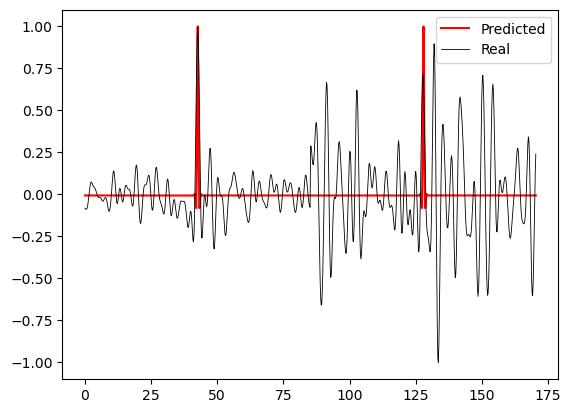

In [1098]:
wave_num = 30
data_pred = predict(geom, model)
time = np.linspace(0, 0.2*2*426, data_pred.shape[1])
time_shift = time + 0.
plt.plot(time, data_pred[wave_num,:], 'r', label="Predicted")
plt.plot(time_shift,data_real[wave_num,:], 'black', linewidth=0.6, label="Real")
plt.legend()
plt.show()
